# Background:
- The impact from COVID-19 isn't spread across all communities evenly, and not all communities have the same level of access to healthcare infrastructure. Therefore, vaccination distribution based on population density alone and/or healthcare infrastructure is not an equitable solution. 

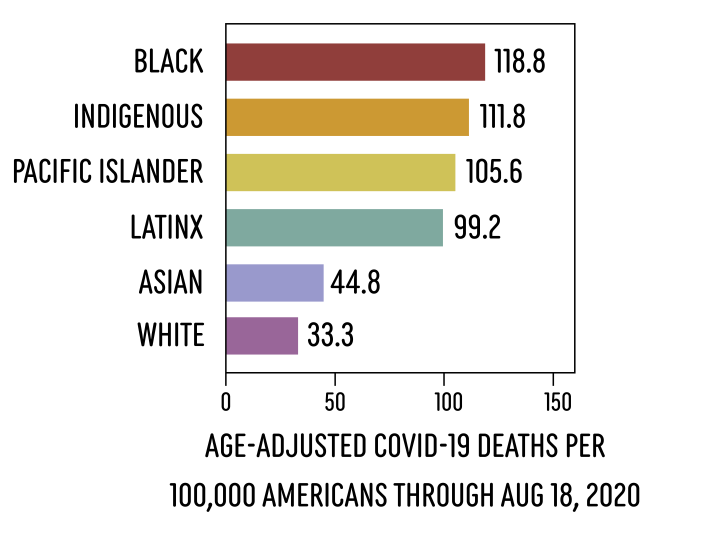

In [ ]:
# Li, W. (2020, October 24). Racial Disparities in COVID-19. Science in the News. http://sitn.hms.harvard.edu/flash/2020/racial-disparities-in-covid-19/
Image('/content/CovidRacialDisparities_Figure-1 (1).png', width=500, height=300)

# Project Goal:  
- To use unsupervised weighted centroid-based clustering and Block Group level Census demographic data to determine equitable vaccine distribution sites.   
  
    
- To create a web app that will allow users to spatially compare the current distribution of vaccine sites against the suggested sites with equity taken into account.

# Flowchart

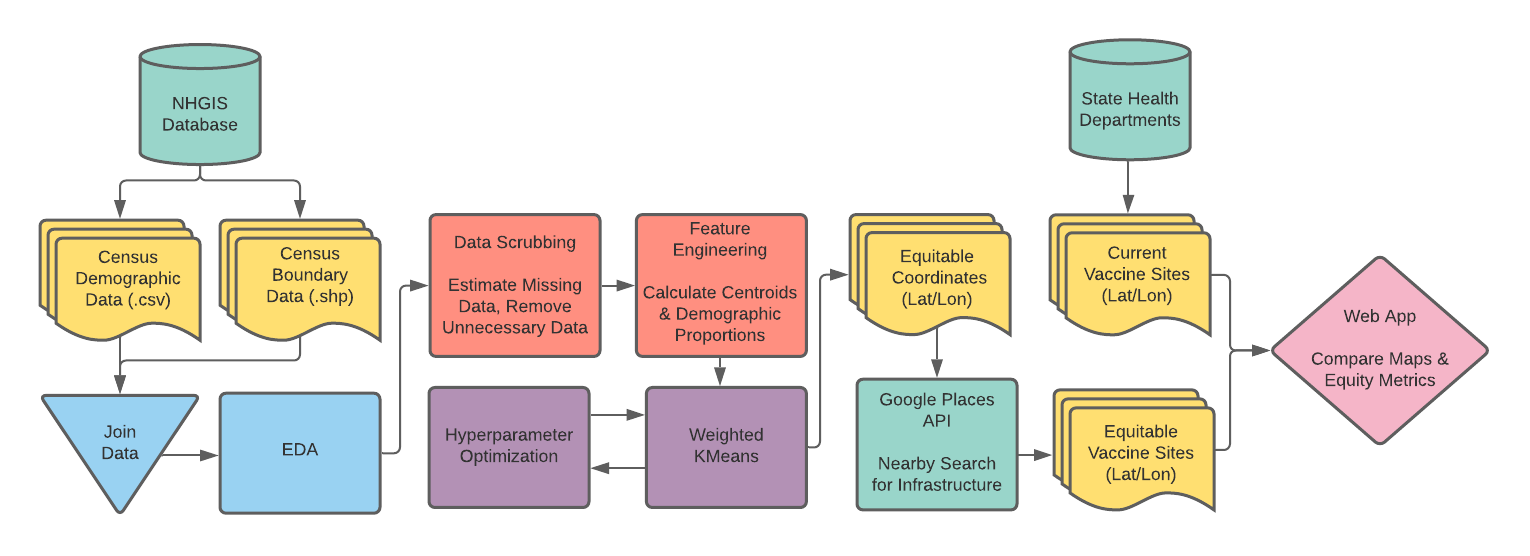

In [ ]:
from IPython.display import Image
Image('/content/TIMELINE.png', width=900, height=300)

# Progress so far:  

- **Data Gathering**: Collected Census data from NHGIS
  - Tabular demographic data: population, race
  - Spatial boundaries for blockgroups 

- **Data Scrubbing**: removed unnecessary data and blockgroups that contained a population of zero (airports, industrial areas, etc.) 

- **Feature Engineering**: calculated demographic proportions per blockgroup

- **Joined Data**: joined tabular census data to spatial boundaries using QGIS  

- **Subset data**: extracted data for only the ten counties of interest:
  - Travis County, TX
  - Bastrop County TX 
  - East Baton Rouge Parish, LA
  - Hinds County, MS
  - Mobile County, AL.
  - Chatham County, GA
  - DeKalb County, GA
  - Fulton County, GA
  - Richland County, SC
  - Baltimore City, MD
  
- **Feature Engineering**: calculated centroids of every blockgroup for each county using QGIS

- **EDA**: conducted EDA for county and state data


# Currently Woring On:  

- **Geolocating current vaccination sites**: each state has a different method for displaying this information to the public. Some states are better than others...


- **Distance to sites**: Calculating Average distance to closest site for majority white communities and majority non-white communities.   


# Next Steps:  

- **Creating custom weighted clustering algorithms**: test out different weighting schemes and different clustering algorithms

In [ ]:
import pandas as pd
pd.set_option('float_format', '{:.3f}'.format)
#pd.reset_option('display.float_format')
import os
from google.colab import drive
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import random 
import numpy as np

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = '/content/drive/MyDrive/Capstone_KMeans/processedCSV/'
new_csv_paths = []

for path in os.listdir(dir):
  new_csv_paths.append(os.path.join(dir,path))
  print(f'Found file for {path[:-13]}')
print(f'\nTotal: {len(new_csv_paths)} CSV files!')

Found file for SC
Found file for AL
Found file for GA
Found file for LA
Found file for MS
Found file for TX
Found file for MD

Total: 7 CSV files!


In [ ]:
dir2 = '/content/drive/MyDrive/Capstone_KMeans/county_csv/'
county_csv_paths = []

for path in os.listdir(dir2):
  if path[-4:]=='.csv':
    county_csv_paths.append(os.path.join(dir2,path))
    print(f'Found file for {path[:-4]}')
print(f'\nTotal: {len(county_csv_paths)} CSV files!')

Found file for richland_sc
Found file for chatham_ga
Found file for baltcity_md
Found file for dekalb_ga
Found file for mobile_al
Found file for fulton_ga
Found file for travis_tx
Found file for hinds_ms
Found file for bastrop_tx
Found file for east_baton_rouge_la

Total: 10 CSV files!


In [ ]:
# set new col names so csvs match
new_cols = ['GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'Shape_Leng', 'Shape_Area', 'new_YEAR', 'STATE',
       'COUNTY', 'new_COUN_1', 'new_TRACT', 'new_BLKGRP', 'new_GEOID',
       'TOTAL_POP', 'WHITE_POP', 'PERCENT_WHITE', 'GISJOIN_2', 'STATEFP_2',
       'COUNTYFP_2', 'TRACTCE_2', 'BLKGRPCE_2', 'GEOID_2', 'NAMELSAD_2',
       'MTFCC_2', 'FUNCSTAT_2', 'ALAND_2', 'AWATER_2', 'INTPTLAT_2',
       'INTPTLON_2', 'Shape_Le_1', 'Shape_Ar_1']

In [ ]:
def plotviolin(x,title):
  csv=plt.cm.tab20c(np.arange(2)/2.)
  plt.figure(figsize=(5,2))
  ax=sns.violinplot(x = x,color=csv[1]);
  plt.xlabel(None)
  plt.title(title)
  plt.axvline(x.median(),ymax=.5, color='k', linestyle='dashed', linewidth=1)  

def plotdonut(df,title):
  plt.figure(figsize=(5,5))
  #print('here',float(df['TOTAL_POP']).dtypes)
  tot_pop = float(df['TOTAL_POP'].sum())
  wh_pop = float(round(df['WHITE_POP'].sum()/tot_pop,3))
  non_wh_pop = round(1 - wh_pop,3)

  size_of_groups=[wh_pop,non_wh_pop]
  cs=plt.cm.tab20c(np.arange(2)/2.)
  plt.pie(size_of_groups,colors=cs)
  plt.title(title)
  plt.legend(['White Pop.:        '+str(round(wh_pop,4)*100)+'%','Non-White Pop.: '+str(round(non_wh_pop,4)*100)+'%'],loc='best')
  my_circle=plt.Circle( (0,0), 0.7, color='white')
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

def plot_data(c_path,s_path):
  dfc = pd.read_csv(c_path, encoding='utf8')
  dfs = pd.read_csv(s_path, encoding='utf8')
  #dfc.columns = new_cols
  dfc=dfc.rename(columns = {'new_STATE':'STATE','new_COUNTY':'COUNTY','new_TOTAL_':'TOTAL_POP','new_PERCEN':'PERCENT_WHITE','new_WHITE_':'WHITE_POP',}) 
  print('\n',str(pd.Series(dfc['COUNTY'].value_counts()).index[0])+',',dfc['STATE'].unique()[0],'Stats:\n')
 
  stat_dfc = pd.DataFrame(dfc.agg({'TOTAL_POP':['count','mean','median','min','max','sum'],\
        'PERCENT_WHITE':['count','mean','median','min','max','sum']}))
  stat_dfc.columns = ['Population','Percent White']
  print(stat_dfc,'\n')
  
  print('\n',dfc['STATE'].unique()[0],'Stats:\n')
  stat_dfs = pd.DataFrame(dfs.agg({'TOTAL_POP':['count','mean','median','min','max','sum'],\
        'PERCENT_WHITE':['count','mean','median','min','max','sum']}))
  stat_dfs.columns = ['Population','Percent White']
  print(stat_dfs,'\n')
  
  #plotviolin(dfc['TOTAL_POP'],"Population per BG (County)")
  #plotviolin(dfs['TOTAL_POP'],"Population per BG (State)")
  
  plotviolin(dfc['PERCENT_WHITE'],"Percent of White Population per BG (County)")
  print('')
  plotviolin(dfs['PERCENT_WHITE'],"Percent of White Population per BG (State)")

  plotdonut(dfc,"Demographics (County)")
  plotdonut(dfs,"Demographics (State)")

In [ ]:
plot_data(county_csv_paths[4],new_csv_paths[1])


 Baltimore city, Maryland Stats:

        Population  Percent White
count      650.000        650.000
mean       936.972          0.258
median     839.000          0.111
min          8.000          0.000
max       3849.000          1.000
sum     609032.000        167.527 


 Maryland Stats:

        Population  Percent White
count     3903.000       3903.000
mean      1542.108          0.518
median    1374.000          0.565
min          6.000          0.000
max       8987.000          1.000
sum    6018848.000       2020.632 




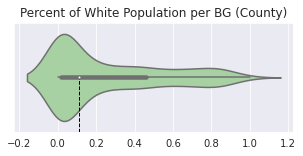

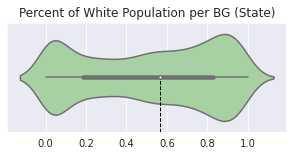

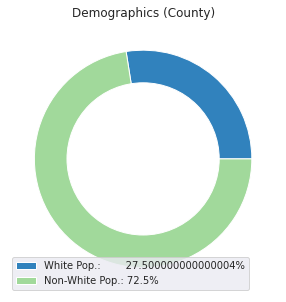

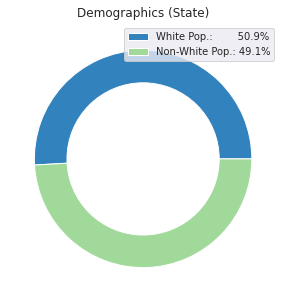

In [ ]:
plot_data(county_csv_paths[2],new_csv_paths[6])


 Richland County, South Carolina Stats:

        Population  Percent White
count      245.000        245.000
mean      1679.008          0.424
median    1173.000          0.365
min        100.000          0.000
max      14051.000          1.000
sum     411357.000        103.985 


 South Carolina Stats:

        Population  Percent White
count     3039.000       3039.000
mean      1652.124          0.611
median    1344.000          0.659
min         28.000          0.000
max      16784.000          1.000
sum    5020806.000       1856.318 




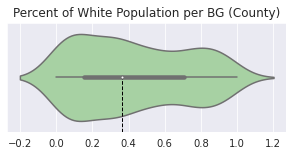

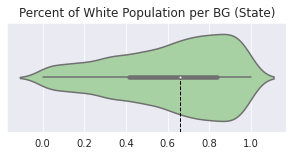

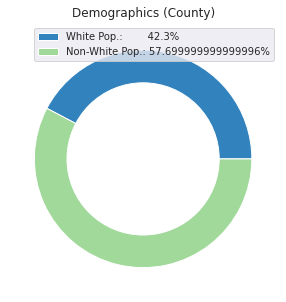

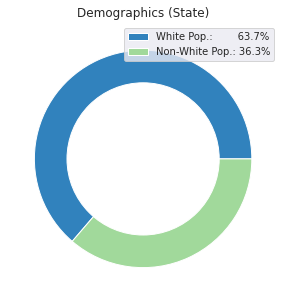

In [ ]:
plot_data(county_csv_paths[0],new_csv_paths[0])

In [ ]:
plot_data(county_csv_paths[1],new_csv_paths[2])

In [ ]:
plot_data(county_csv_paths[3],new_csv_paths[2])

In [ ]:
plot_data(county_csv_paths[5],new_csv_paths[2])

In [ ]:
plot_data(county_csv_paths[6],new_csv_paths[5])

In [ ]:
plot_data(county_csv_paths[7],new_csv_paths[4])

In [ ]:
plot_data(county_csv_paths[8],new_csv_paths[5])

In [ ]:
plot_data(county_csv_paths[9],new_csv_paths[3])

### Geolocating Current Vaccination Sites Per State and Calculating Average Distance to Sites by Community

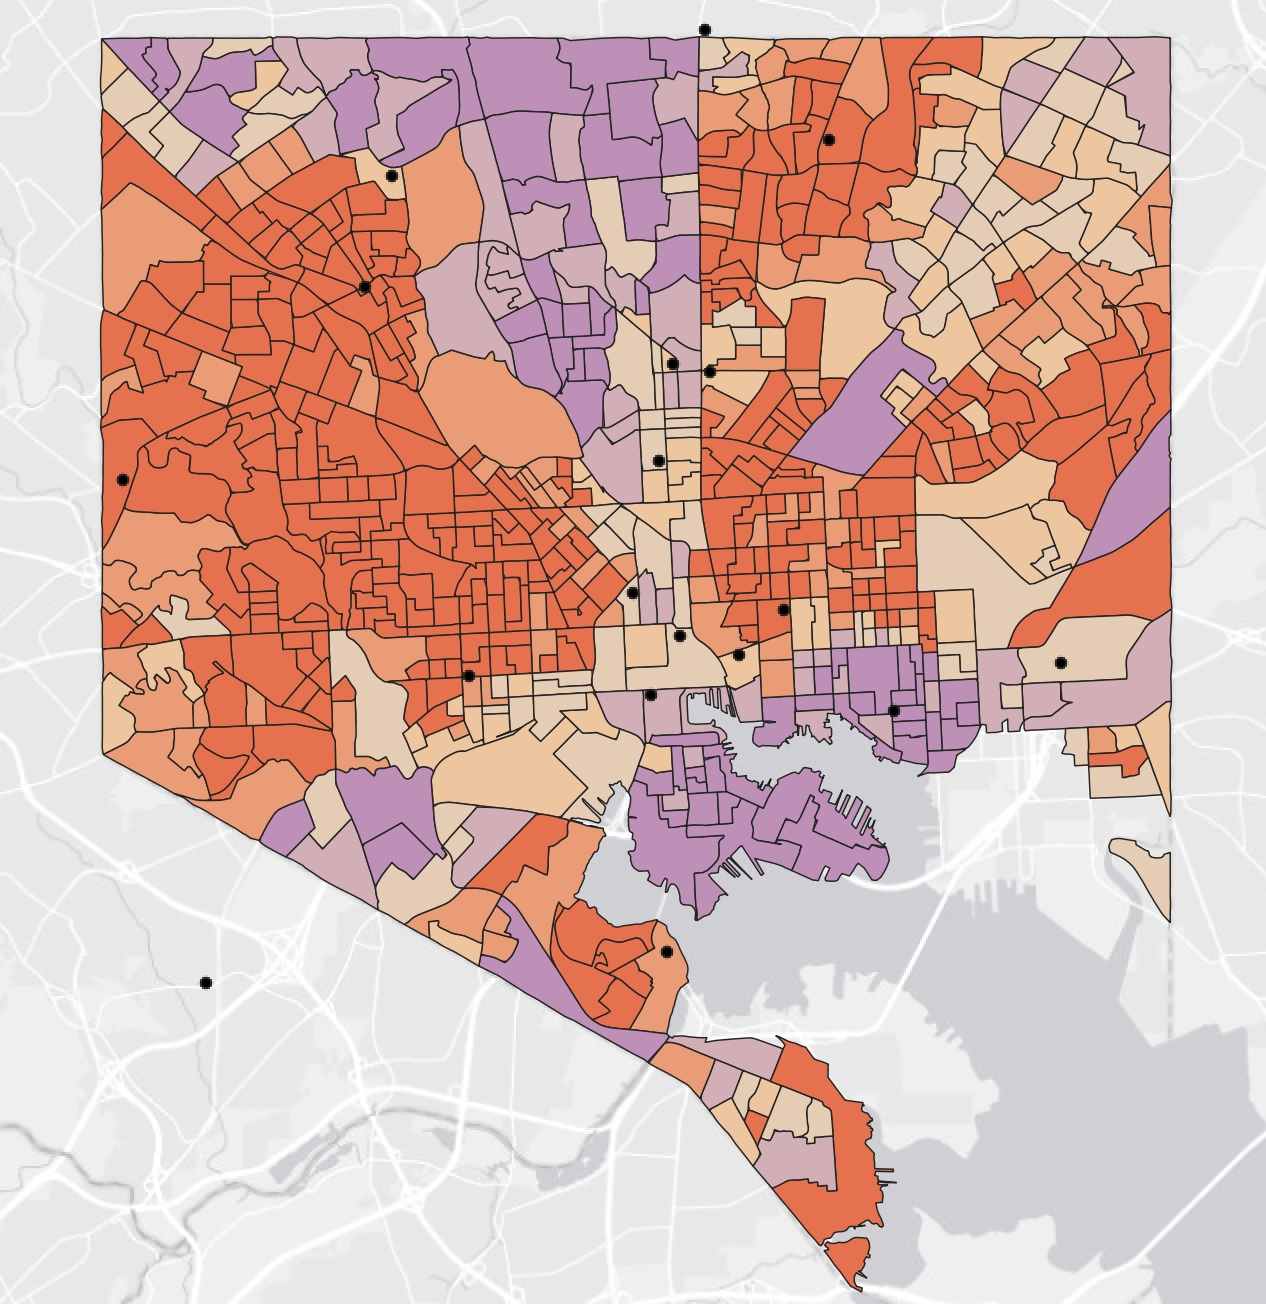

In [ ]:
# Baltimore City, MD
from IPython.display import Image
Image('/content/Screen Shot 2021-02-22 at 4.00.57 PM.jpg', width=500, height=500)

Using QGIS and Excel:
Average distance to closest site for majority white communities and majority non-white communities  

Including sites outside the county:
- Majority white    : 1.0035 miles
- Majority non-white: 1.1041 miles  

Excluding sites outside the county:
- Majority white    : 1.0868 miles
- Majority non-white: 1.1518 miles